# 1. Importar dependencias y librerías:

In [1]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive


In [2]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset

In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head()

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,es,Nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence
1,EXIST2021,2,twitter,es,"@lindagisela74 Que rica putita obediente, afor...",sexist,stereotyping-dominance
2,EXIST2021,3,twitter,es,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,non-sexist
3,EXIST2021,4,twitter,es,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist
4,EXIST2021,5,twitter,es,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,non-sexist


In [5]:
#2.Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos como el id, el testcase, etc. Nos vamos a quedar tan solo con el texto y las labels
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df = df.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afor...",stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [6]:
# 3.Necesitamos saber cuales son los valores únicos de nuestras etiquetas para cambiarlas a valores numéricos:
Etiquetas = df['label'].unique()

In [7]:
Etiquetas

array(['sexual-violence', 'stereotyping-dominance', 'non-sexist',
       'misogyny-non-sexual-violence', 'ideological-inequality',
       'objectification'], dtype=object)

In [8]:
#4. Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality','objectification'],[0, 1, 2 , 3, 4, 5])

In [9]:
#5.Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()

In [10]:
#Revisamos como ha quedado nuestra tabla:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",2
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


### 2.1 - *Separamos el dataset en varios conjuntos (Train, Validación y Test)*

In [11]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [12]:
# Convertimos nuestros splits en tipo Dataset:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [13]:
#Los conbinamos en un solo dataset:

tweets  = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

tweets = tweets.remove_columns(["__index_level_0__"])

In [14]:
tweets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

### 3 - Descarga del modelo y su tokenizador:

In [15]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = "distilbert-base-uncased"
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=512, truncation = True)

In [17]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
tweets_Encoded = tweets.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [18]:
tweets_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [19]:
#Ahora que hemos codificado el texto, lo eliminamos de nuestro diccionarios ya que no es necesario:
#TWS_Encoded = TWS_Encoded.remove_columns(['text'])

In [20]:
#Necesitamos que los objetos sean de tipo torch
tweets_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [21]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality','objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'non-sexist',
  '1': 'sexual-violence',
  '2': 'stereotyping-dominance',
  '3': 'misogyny-non-sexual-violence',
  '4': 'ideological-inequality',
  '5': 'objectification'},
 {'non-sexist': '0',
  'sexual-violence': '1',
  'stereotyping-dominance': '2',
  'misogyny-non-sexual-violence': '3',
  'ideological-inequality': '4',
  'objectification': '5'})

In [23]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 6, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4. Definimos los hyperparametros:

In [24]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [25]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-sexism_detection"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [26]:
# Entrenemos el modelo con la API Trainer:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = tweets_Encoded["train"],
  eval_dataset = tweets_Encoded["val"],
  tokenizer = tokenizer)

In [27]:
gc.collect()
torch.cuda.empty_cache()

In [28]:
#5.Entrenamos nuestro modelo:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.242100,1.156793,0.579876,0.527716
2,1.056500,1.089890,0.595763,0.599389
3,0.884200,1.055118,0.633716,0.629668


TrainOutput(global_step=3399, training_loss=1.081323761138961, metrics={'train_runtime': 1336.5932, 'train_samples_per_second': 20.342, 'train_steps_per_second': 2.543, 'total_flos': 3601913023752192.0, 'train_loss': 1.081323761138961, 'epoch': 3.0})

### Matriz de Confusión

In [29]:
preds_output = trainer.predict(tweets_Encoded["val"])

In [30]:
preds_output.metrics

{'test_loss': 1.0551176071166992,
 'test_accuracy': 0.6337157987643425,
 'test_f1': 0.6296681799781492,
 'test_runtime': 6.7051,
 'test_samples_per_second': 168.975,
 'test_steps_per_second': 21.178}

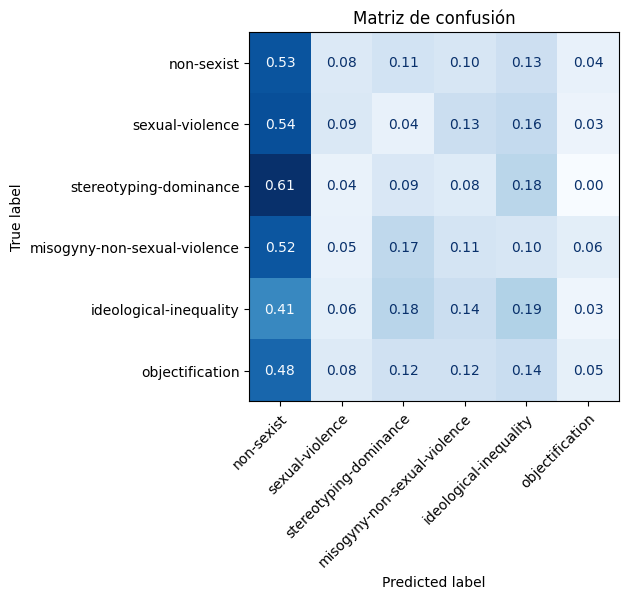

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["val"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)
# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("Matriz de confusión")
plt.show()

In [32]:
preds_output = trainer.predict(tweets_Encoded["test"])
preds_output.metrics



{'test_loss': 1.0688008069992065,
 'test_accuracy': 0.6257722859664607,
 'test_f1': 0.6205777977977076,
 'test_runtime': 10.9425,
 'test_samples_per_second': 103.542,
 'test_steps_per_second': 12.977}

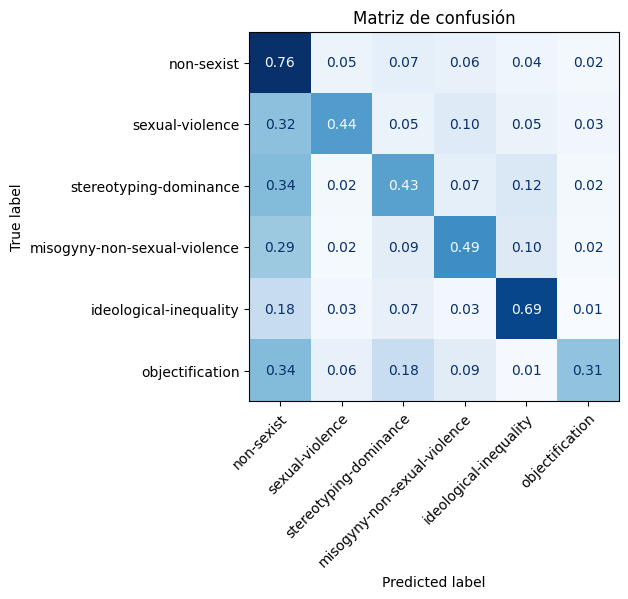

In [50]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["test"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)

# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Matriz de confusión")
plt.show()

# Guardamos el modelo:


In [34]:
model.save_pretrained(
  os.path.join(path_model, 'distilbert-base-uncased-finetuned-detección-sexismo'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'distilbert-base-uncased-finetuned-detección-sexismo'))

('/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/tokenizer_config.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/special_tokens_map.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/vocab.txt',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/added_tokens.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/tokenizer.json')

# Análisis del validation loss

In [35]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [36]:
tweets_Encoded["val"] = tweets_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [37]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [38]:
tweets_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tweets_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [53]:
from IPython.display import display

In [55]:
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
149,"https://t.co/pBzAmUNOO3Esta noticia me rompió el corazón. Piensa mi amigo, y si te pasara a ti o a algún ser querido seguirias siendo un pagafantas? Razón del porqué el #MeToo es una aberración",ideological-inequality,non-sexist,5.657363
251,"@AlleyDalley Tuvo que ser un puritano expresando impulsos reprimidos, estoy seguro",sexual-violence,non-sexist,5.572735
879,"Hoy hablamos sobre las diferencias entre el abuso y la agresión, comentamos la sentencia de #lamanadaPuedes escucharlo aquí: https://t.co/0acPMjBTcH",sexual-violence,non-sexist,5.544590
215,@Benholm @hari_fightclub @margaritaevna95 Es una táctica clásica usada contra las mujeres durante milenios para debilitarlas reduciéndolas a objetos. Así que esa es mi desvarío feminista.. No todo el feminismo es malo. Algunas observaciones siguen siendo válidas incluso ahora,objectification,ideological-inequality,5.206197
1081,"Quién les hizo tanto daño Una habla de #NiUnaMenos o #MeToo, pero a estos batos lo peor que les puede pasar es no tener ligues. Bola de pendejos. https://t.co/5RnZea5J9K",ideological-inequality,non-sexist,5.068065
831,"He tenido esto. Bien significa que estoy seguro...""No te preocupes por venir a la reunión - estoy seguro de que tus pequeños te necesitan más que nosotros"". ""Aproveche al máximo su tiempo con ellos"". ""Vaya y esté con su familia Amy"".......Voy a decidir sobre eso muchas gracias. #everydaysexism https://t.co/LlcPAf7hoU",stereotyping-dominance,non-sexist,5.030781
866,"#naucalpan #edomex #infielesTengo amigas que me decían hasta con orgullo que son infieles, neta son muy infelices, no importa cuantos amantes tengan, jamas tienen llevadera, daban lastima, de hecho varias de ellas se suicidaron, valórense amigas.https://t.co/1YuEf9ooZA",stereotyping-dominance,non-sexist,5.018447
930,@NinjaSocialist @BynameRose @Ponder_O_Purg @GameOverRos @natsprat3 @annaeck73 @shahjoffe @OustideVoice @EXPELincels @Elfskin7 @CrossBidy @Holdenheim1 @3nigmatic_01 @jools6691 @KRblx123 @blackishmonday @SuperRealScott @beeonroids @GreatMi64424995 @SR_Duncan @j_bbrav0 @TwitchyMac @DredSadie @MgtowRadical @FCDaran @KLKnight81 @AvaGraceVip @Lecanardnoir @Falconer084 @TwenGrit @Kafi @MedusaHypatyPatyPatia @sandsquist@Gen@Gen@Gen@Gen@Gen@G,objectification,non-sexist,4.967762
106,Empiezo manspreading mucho más en botas demasiado bc es más cómodo para sentarse de esa manera ... lo siento jugadores,stereotyping-dominance,non-sexist,4.821861
43,"Sí, sabemos lo borracho que era y lo que sigue siendo Killary, esperando a que su hígado se entregue.",misogyny-non-sexual-violence,non-sexist,4.722925


In [56]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
262,"#HILO | ¡NECESITA DE LA SOLIDARIDAD DE TODOS!Una menor de 15 años y embarazada de 6 meses, se encuentra internada por #COVID_19 en Terapia Intensiva en IPS de Encarnación. Sus familiares están desesperados ya que son de escasos recursos (se dedican a la venta de yuyos). https://t.co/36Wb6x5E1X",non-sexist,non-sexist,0.027095
324,"El destierro violento de personas sin hogar y sus tiendas de campaña está sucediendo en todo el país. Está sucediendo en Minneapolis durante el frígido invierno. Esto habla de la crisis nacional sin hogar impulsado por la mercantilización de la vivienda, pero también los funcionarios locales pueden detener esto. https://t.co/OdDaiJxcEv",non-sexist,non-sexist,0.027598
77,"Popeye' el cachorro puede ser fuerte, pero tiene Wellesley y Dover primeros respondedores para agradecer por sacarlo del agua helada del río Charles. https://t.co/O8cn4HCkJp",non-sexist,non-sexist,0.027997
328,"cuando deciamos q llevan yendo a saco a por Dayane durante 5 meses xq la ven fuerte y q puede con todo,pero q esta vez habian sobrepasado los limites x la situacion q esta viviendo y q iba a explotar x algun lado? teniamos razon y hoy fue el dia y NO merece y me parte el alma",non-sexist,non-sexist,0.030405
1109,"El Senado de EEUU aprueba por estrecha mayoría el nombramiento de Christopher Waller a la junta directiva de la Reserva Federal, dando su visto bueno a otra selección del presidente Donald Trump tras una serie de sonados rechazos. https://t.co/Ua1DC2uVUf",non-sexist,non-sexist,0.030502
327,"Todo el mundo, por favor escuchen, estoy enamorado de Changbin, tengo un gran enamoramiento gordo en Changbin /hj",non-sexist,non-sexist,0.030905
686,"-No he conseguido el agua de coco. Me la van a conseguir a las 2 de la tarde. Si cuando vuelva no has fregado todo eso, vas a tener problemas, que webonada es.Yo no quería fregar pues.Mi hermano cuando mi papa lo arrastró dentro del carro: https://t.co/ZJ5yYtgLKy",non-sexist,non-sexist,0.031399
41,"@anluma99 @abulelrafas Mal que lo hubiera hecho como miembro del partido, pero es que... joder, era juez. Aunque el historial de Enrique López en cuanto a su estrecha vinculación al PP es largo..Y luego se asombran, fingidamente, porque creamos que la justicia está atestada de intereses políticos.",non-sexist,non-sexist,0.031455
753,¿Fue la cruzada de los 2010s un psyop o fue real? ¿Sabemos,non-sexist,non-sexist,0.032461
42,"@phasteI estábamos viendo exponiendo infieles, y creiamos q la chica iba a estar embarazada pero resultó q hizo una peli xxx y se rió, están sacando un poco de contexto las cosas",non-sexist,non-sexist,0.032622
